In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
import shap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


file_path = 'creditcard_2013.csv'
data = pd.read_csv(file_path)

X = data.drop(['Class', 'Time'], axis=1)
tot_seconds = data['Time']
X['sin_tot_seconds'] = np.sin(2 * np.pi * tot_seconds / (24 * 60 * 60))
X['cos_tot_seconds'] = np.cos(2 * np.pi * tot_seconds / (24 * 60 * 60))
X['Extra'] = 0
amount_pt = PowerTransformer(method='box-cox')
X['Amount'] = amount_pt.fit_transform(X[['Amount']] + 1e-9)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)#

y = data['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:

class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_classes):
        super(TransformerModel, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, batch_first=True)
        self.fc1 = nn.Linear(input_dim, 2)
        self.fc2 = nn.Linear(2, num_classes)

    def forward(self, x):
        # x = x.unsqueeze(1)
        attn_output, _ = self.attention(x, x, x)
        x = x + attn_output
        x = torch.relu(self.fc1(x.mean(dim=1)))
        x = torch.sigmoid(self.fc2(x))
        return x

model = TransformerModel(input_dim=X_train.shape[1], num_heads=4, num_classes=1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1)), batch_size=32, shuffle=True)

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

model_save_path = 'transformer_shap_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# model.eval()
# with torch.no_grad():
#     predictions = model(X_test_tensor)
#     predictions = (predictions > 0.5).float()
#     accuracy = (predictions.squeeze() == y_test_tensor).float().mean()
#     print(f'Test Accuracy: {accuracy:.4f}')

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Epoch 1/1, Loss: 0.0001
Model saved to transformer_shap_model.pth


  0%|          | 0/200 [00:00<?, ?it/s]

SHAP values shape: (200, 32)
Test data shape: (200, 32)


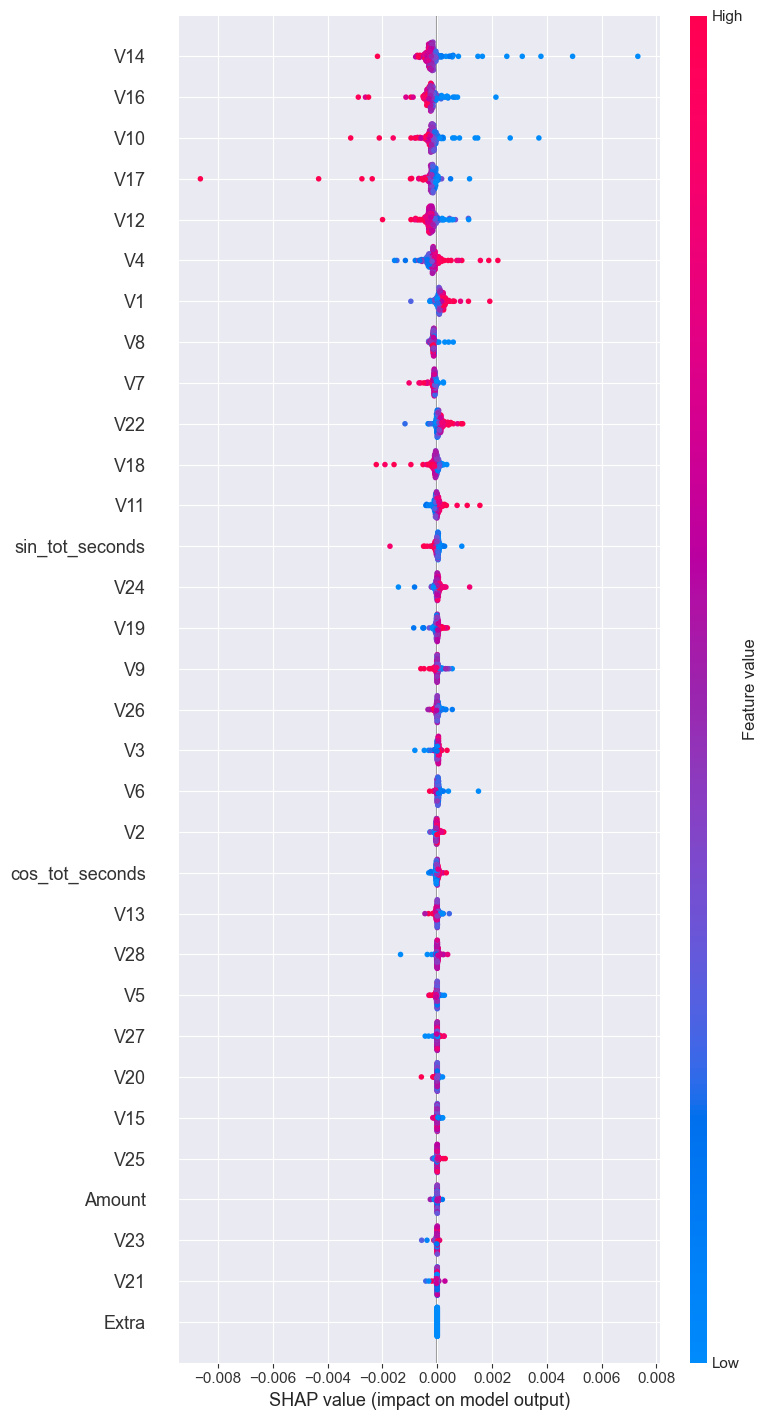

In [32]:

def model_predict(data):
    data_tensor = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        output = model(data_tensor.unsqueeze(1)).numpy()
        return output.reshape(-1, 1)

background = shap.sample(X_train_tensor.numpy(), 1000)
test_data = X_test_tensor[300:500].numpy()

explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(test_data)

if isinstance(shap_values, list):
    shap_values = shap_values[0]

shap_values = np.squeeze(shap_values)

print(f"SHAP values shape: {shap_values.shape}")
print(f"Test data shape: {test_data.shape}")

shap.summary_plot(shap_values, test_data, feature_names=list(X.columns), max_display=len(X.columns))
